<a href="https://colab.research.google.com/github/yumi-h-1/Predicting-Bank-Customer-Churn/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Import libraries

In [ ]:
# Import libraries
from joblib import dump, load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time
import warnings
#Set warnings ingored
warnings.filterwarnings('ignore')

### 2. Final MLP model

### 2.1. Import the final MLP model

In [ ]:
# First, define the final MLP model structure
class final_MLP(nn.Module):
    def __init__(self, input_size, hidden_units1, hidden_units2, output_size):
        super(final_MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units1)
        self.fc2 = nn.Linear(hidden_units1, hidden_units2)
        self.fc3 = nn.Linear(hidden_units2, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

In [ ]:
# Define the size and units in the final MLP model
input_size = 10
output_size = 1
hidden_units1 = 6
hidden_units2 = 4

In [ ]:
# Load the final MLP model
best_MLP_model = final_MLP(input_size, hidden_units1, hidden_units2, output_size)
best_MLP_model.load_state_dict(torch.load('best_mlp_model.pth'))

<All keys matched successfully>

### 2.2. Load the test set for the final MLP model

In [ ]:
# Load X_test and y_test for the MLP model
X_test_mlp = torch.load('X_test_for_MLP.pth')
y_test_mlp = torch.load('y_test_for_MLP.pth')

In [ ]:
# Define the batch size
batch_size = 64 # Match the number used for training

### 2.3. Test the final MLP model

In [ ]:
# Record the starting time
start_time = time.time()

# Test the MLP model
best_MLP_model.eval()

# Make variables to track correct predictions and total counts in y_test
correct = 0
total = 0

with torch.no_grad():
    for batch_X_test, batch_y_test in zip(X_test_mlp, y_test_mlp):
        outputs_test = best_MLP_model(batch_X_test)
        # Convert test outputs to predicted class as 0 or 1
        predicted = (outputs_test > 0.5).float()
        # Count total counts in y_test and correct predictions
        total += batch_y_test.size(0)
        correct += (predicted == batch_y_test).sum().item()

# Record the ending time
end_time = time.time()

# Calculate accuracy
accuracy = correct / total
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f'Test time of MLP model: {elapsed_time:.2f} seconds')

Test Accuracy: 86.32%
Test time of MLP model: 2.83 seconds


### 3. Final SVM model

### 3.1. Import the final SVM model

In [ ]:
# Load the final SVM model
best_SVM_model = load('best_svm_model.joblib')

### 3.2. Load the test set for the final SVM model

In [ ]:
# Load X_test and y_test
X_test_svm = pd.read_csv('X_test_for_SVM.csv', header=None)
y_test_svm = pd.read_csv('y_test_for_SVM.csv', header=None)

In [ ]:
# Check X_test
X_test_svm.head(2)

,0,1,2,3,4,5,6,7,8,9
0,0.896,0.0,0.0,0.175676,0.8,0.406842,0.000000,1.0,0.0,0.397867
1,0.558,0.0,1.0,0.108108,0.6,0.000000,0.333333,1.0,0.0,0.190914


In [ ]:
# Check y_test
y_test_svm.head(2)

,0
0,0.0
1,0.0


In [ ]:
# Check the value and dimention of X_test and y_test
print(type(X_test_svm))
print(type(y_test_svm))
print(X_test_svm.shape)
print(y_test_svm.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(33007, 10)
(33007, 1)


In [ ]:
# Convert Pandas to Numpy array
X_test_svm = X_test_svm.values
y_test_svm = y_test_svm.values

In [ ]:
# Double-check the value and dimension of X_test and y_test
print(type(X_test_svm))
print(type(y_test_svm))
print(X_test_svm.shape)
print(y_test_svm.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(33007, 10)
(33007, 1)


### 3.3. Test the final SVM model

In [ ]:
# Record the starting time
start_time = time.time()

# Test the SVM model
predictions = best_SVM_model.predict(X_test_svm)
# Calculate the accuracy
test_accuracy = accuracy_score(y_test_svm, predictions)

# Record the ending time
end_time = time.time()

print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f'Test time of SVM model: {elapsed_time:.2f} seconds')

Test Accuracy: 85.73%
Test time of SVM model: 63.88 seconds


### 4. Compare MLP and SVM models.

### 4.1. ROC Curve

In [ ]:
# Import the library
from sklearn.metrics import roc_curve, auc

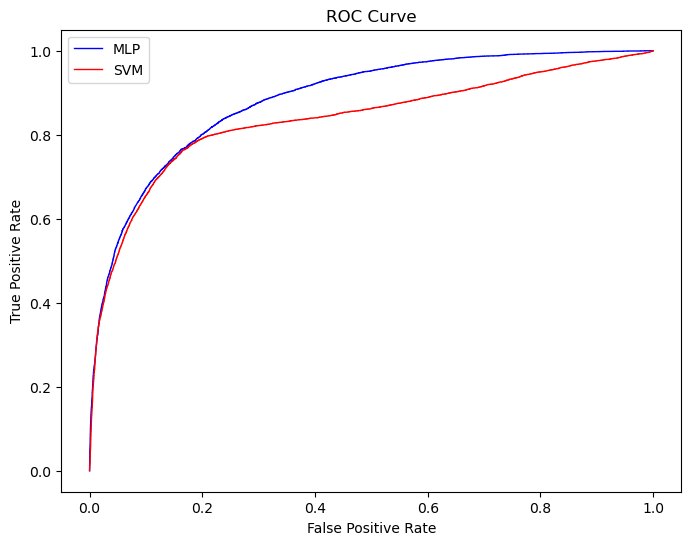

In [ ]:
# Get predicted probabilities from the MLP model
probs_mlp = []
with torch.no_grad():
    for batch_X_test in X_test_mlp:
        outputs_test = best_MLP_model(batch_X_test)
        probs_mlp.extend(outputs_test.numpy())

# Get predicted probabilities from the SVM model
probs_svm = best_SVM_model.decision_function(X_test_svm)

# Calculate ROC curve of MLP model
fpr_mlp, tpr_mlp, thresholds = roc_curve(y_test_mlp, probs_mlp)

# Calculate ROC curve of SVM model
fpr_svm, tpr_svm, thresholds = roc_curve(y_test_svm, probs_svm)

# Plot ROC curves of two models
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='blue', lw=1, label='MLP')
plt.plot(fpr_svm, tpr_svm, color='red', lw=1, label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### 4.2. AUC

In [ ]:
# Calculate the AUC for each model
auc_mlp = auc(fpr_mlp, tpr_mlp)
auc_svm = auc(fpr_svm, tpr_svm)
print(f"AUC of the MLP model: {auc_mlp:.2f}")
print(f"AUC of the SVM model: {auc_svm:.2f}")

AUC of the MLP model: 0.89
AUC of the SVM model: 0.84


### 4.3. Precision-Recall Curve

In [ ]:
# Import the library
from sklearn.metrics import precision_recall_curve, average_precision_score

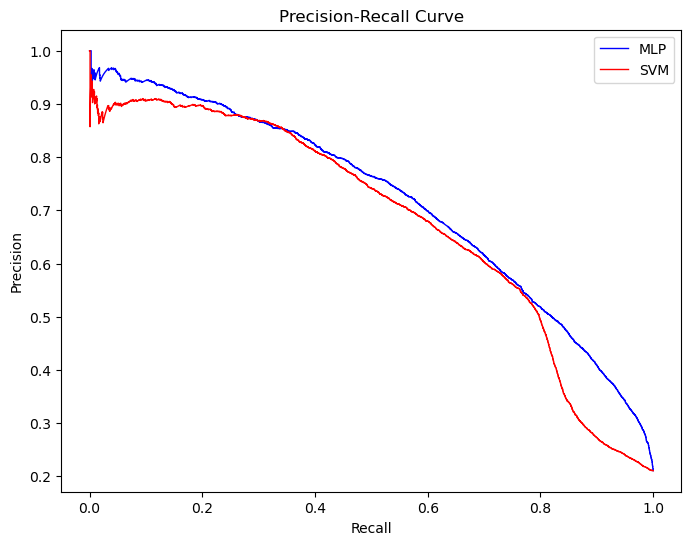

In [ ]:
# Get precision-recall curve for MLP model
precision_mlp, recall_mlp, thresholds = precision_recall_curve(y_test_mlp, probs_mlp)

# Get precision-recall curve for SVM model
precision_svm, recall_svm, thresholds = precision_recall_curve(y_test_svm, probs_svm)

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_mlp, precision_mlp, color='blue', lw=1, label='MLP')
plt.plot(recall_svm, precision_svm, color='red', lw=1, label='SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

### 4.4. Average precision score

In [ ]:
#Calculate the average precision score for each model
average_precision_mlp = average_precision_score(y_test_mlp, probs_mlp)
average_precision_svm = average_precision_score(y_test_svm, probs_svm)
print(f"Average Precision of the MLP model: {average_precision_mlp:.2f}")
print(f"Average Precision of the SVM model: {average_precision_svm:.2f}")

Average Precision of the MLP model: 0.72
Average Precision of the SVM model: 0.68
